In [1]:
#this is needed when running in google colab to specify that version 1.x of tensorflow must
# be used; it just throws an error if run in a regular jupyter notebook.
%tensorflow_version 1.x 

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/avantishrikumar/ana

In [3]:
keras_model = model_from_json(open("keras2_conv1d_record_5_model_PQzyq_modelJson.json").read())
keras_model.load_weights("keras2_conv1d_record_5_model_PQzyq_modelWeights.h5")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [4]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_1 (Activation)    (None, 190, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_2 (Activation)    (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
__________

In [5]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [6]:
inp_tensor = keras.layers.Input((None,4))
conv1_preact = get_out_tensor(inp_tensor=inp_tensor,
                              layer_to_copy=keras_model.layers[0],
                              param_overrides={'padding': 'same'})
conv1 = get_out_tensor(inp_tensor=conv1_preact,
                       layer_to_copy=keras_model.layers[1])
conv2_preact = get_out_tensor(inp_tensor=conv1,
                              layer_to_copy=keras_model.layers[2],
                              param_overrides={'padding': 'same'})
conv2 = get_out_tensor(inp_tensor=conv2_preact,
                       layer_to_copy=keras_model.layers[3])
conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1)
conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2)
concat = keras.layers.Concatenate(axis=-1)([conv1_gap, conv2_gap])
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [7]:
embedding_model.save("embedding_model.h5")

In [26]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 50)     2250        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 50)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 50)     27550       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [8]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

In [31]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

MEMORY 0.392941568
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold
Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


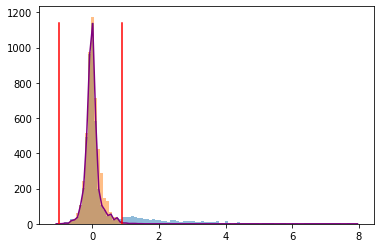

Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Computing threshold
Thresholds from null dist were -0.918197512626648  and  0.608733057975769
Final raw thresholds are -0.918197512626648  and  0.608733057975769
Final transformed thresholds are -0.9040322580645161  and  0.8833870967741936


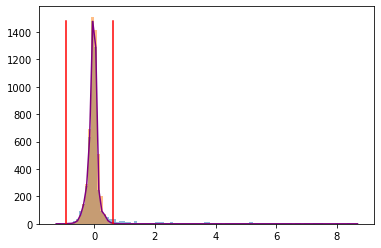

Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Computing threshold
Thresholds from null dist were -0.6213091909885406  and  0.6281718015670776
Final raw thresholds are -0.6213091909885406  and  0.6281718015670776
Final transformed thresholds are -0.8680107526881721  and  0.8682795698924731


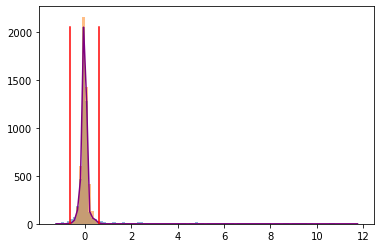

Got 166 coords
After resolving overlaps, got 275 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8401150537634409
MEMORY 0.39079936
275 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [115, 104]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
MEMORY 0.39079936
On metacluster 1
Metacluster size 104
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 104
(Round 1) Computing coarse affmat
MEMORY 0.380203008
Beginning embedding computation


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Finished embedding computation in 0.24 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Finished affinity matrix computations in 0.02 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.381038592
Computed nearest neighbors in 0.01 s
MEMORY 0.381038592
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.381038592
Launching nearest neighbors affmat calculation job
MEMORY 0.381894656
Parallel runs completed
MEMORY 0.357953536
Job completed in: 0.72 s
MEMORY 0.357953536
Launching nearest neighbors affmat calculation job
MEMORY 0.357617664
Parallel runs completed
MEMORY 0.35801088
Job completed in: 0.52 s
MEMORY 0.35801088
(Round 1) Computed affinity matrix on nearest neighbors in 1.31 s
MEMORY 0.356007936
Filtered down to 72 of 104
(Round 1) Retained 72 rows out of 104 after filtering
MEMORY 0.356016128
(Round 1) Computing densi

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3844368760196713
Quality: 0.38833634992084876


100%|██████████| 50/50 [00:00<00:00, 69.10it/s]

Got 7 clusters after round 1
Counts:
{6: 3, 5: 10, 1: 12, 4: 11, 0: 13, 2: 12, 3: 11}
MEMORY 0.354975744
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.354975744
Aggregating for cluster 0 with 13 seqlets
MEMORY 0.354975744


Trimmed 0 out of 13
Skipped 2 seqlets
Aggregating for cluster 1 with 12 seqlets
MEMORY 0.354975744
Trimmed 0 out of 12
Aggregating for cluster 2 with 12 seqlets
MEMORY 0.354975744
Trimmed 0 out of 12
Skipped 2 seqlets
Aggregating for cluster 3 with 11 seqlets
MEMORY 0.354975744
Trimmed 0 out of 11
Skipped 2 seqlets
Aggregating for cluster 4 with 11 seqlets
MEMORY 0.35497984
Trimmed 0 out of 11
Skipped 2 seqlets
Aggregating for cluster 5 with 10 seqlets
MEMORY 0.35497984
Trimmed 0 out of 10
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 3 seqlets
MEMORY 0.35497984
Trimmed 0 out of 3
(Round 2) num seqlets: 63
(Round 2) Computing coarse affmat
MEMORY 0.35497984
Beginning embedding computation
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Finished affinity matrix computations in 0.02 s
(Round 2) Compute

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3812254449084075


100%|██████████| 50/50 [00:00<00:00, 83.22it/s]

Got 7 clusters after round 2
Counts:
{0: 11, 4: 9, 3: 9, 5: 8, 1: 11, 6: 5, 2: 10}
MEMORY 0.355213312
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.355213312
Aggregating for cluster 0 with 11 seqlets
MEMORY 0.355213312


Trimmed 2 out of 11
Aggregating for cluster 1 with 11 seqlets
MEMORY 0.355213312
Trimmed 1 out of 11
Aggregating for cluster 2 with 10 seqlets
MEMORY 0.355213312
Trimmed 1 out of 10
Aggregating for cluster 3 with 9 seqlets
MEMORY 0.355213312
Trimmed 2 out of 9
Aggregating for cluster 4 with 9 seqlets
MEMORY 0.355213312
Trimmed 0 out of 9
Aggregating for cluster 5 with 8 seqlets
MEMORY 0.355213312
Trimmed 0 out of 8
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 5 seqlets
MEMORY 0.355213312
Trimmed 0 out of 5
Got 7 clusters
Splitting into subclusters...
MEMORY 0.355213312
Merging on 7 clusters
MEMORY 0.355213312
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 2 & 5 with prob 4.88380005525596e-06 and sim 1.9471881622654381
Collapsing 0 & 3 with prob 2.1806839967434692e-05 and sim 1.9326778375494642
Collapsing 2 & 6 with prob 1.7283170950313895e-06 and sim 1.9190429430347746
Collapsing 5 & 6 with prob 1.30422207965

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Finished embedding computation in 0.22 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.357269504
Computed nearest neighbors in 0.01 s
MEMORY 0.357269504
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.357269504
Launching nearest neighbors affmat calculation job
MEMORY 0.358121472
Parallel runs completed
MEMORY 0.361156608
Job completed in: 0.62 s
MEMORY 0.361156608
Launching nearest neighbors affmat calculation job
MEMORY 0.361058304
Parallel runs completed
MEMORY 0.36112384
Job completed in: 0.72 s
MEMORY 0.361230336
(Round 1) Computed affinity matrix on nearest neighbors in 1.39 s
MEMORY 0.359358464
Filtered down to 88 of 115
(Round 1) Retained 88 rows out of 115 after filtering
MEMORY 0.359358464
(Round 1) Computing densi

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.44767467232836977
Quality: 0.44829081974581797


100%|██████████| 50/50 [00:00<00:00, 77.00it/s]

Got 7 clusters after round 1
Counts:
{3: 15, 5: 7, 1: 18, 6: 3, 2: 16, 4: 9, 0: 20}
MEMORY 0.35831808
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.35831808
Aggregating for cluster 0 with 20 seqlets
MEMORY 0.35831808


Trimmed 3 out of 20
Skipped 2 seqlets
Aggregating for cluster 1 with 18 seqlets
MEMORY 0.35831808
Trimmed 0 out of 18
Skipped 2 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.35831808
Trimmed 0 out of 16
Skipped 3 seqlets
Aggregating for cluster 3 with 15 seqlets
MEMORY 0.35831808
Trimmed 0 out of 15
Skipped 4 seqlets
Aggregating for cluster 4 with 9 seqlets
MEMORY 0.35831808
Trimmed 0 out of 9
Aggregating for cluster 5 with 7 seqlets
MEMORY 0.35831808
Trimmed 0 out of 7
Skipped 1 seqlets
Aggregating for cluster 6 with 3 seqlets
MEMORY 0.35831808
Trimmed 0 out of 3
(Round 2) num seqlets: 72
(Round 2) Computing coarse affmat
MEMORY 0.35831808
Beginning embedding computation
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.4223168885321788
Quality: 0.4248029322627415
Quality: 0.4248226643956263


100%|██████████| 50/50 [00:00<00:00, 121.94it/s]


Got 6 clusters after round 2
Counts:
{0: 20, 1: 14, 3: 11, 2: 12, 4: 10, 5: 5}
MEMORY 0.357310464
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.357310464
Aggregating for cluster 0 with 20 seqlets
MEMORY 0.357310464
Trimmed 0 out of 20
Aggregating for cluster 1 with 14 seqlets
MEMORY 0.357310464
Trimmed 0 out of 14
Aggregating for cluster 2 with 12 seqlets
MEMORY 0.357310464
Trimmed 1 out of 12
Aggregating for cluster 3 with 11 seqlets
MEMORY 0.357310464
Trimmed 0 out of 11
Aggregating for cluster 4 with 10 seqlets
MEMORY 0.357310464
Trimmed 1 out of 10
Aggregating for cluster 5 with 5 seqlets
MEMORY 0.357310464
Trimmed 0 out of 5
Got 6 clusters
Splitting into subclusters...
MEMORY 0.357310464
Merging on 6 clusters
MEMORY 0.357310464
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 0.0001827210712654645 and sim 1.947388339058052
Collapsing 2 & 3 with prob 9.299845204095108e-05 and sim 1.94708899342647

In [32]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow.workflow)
reload(modisco.tfmodisco_workflow)
reload(modisco.affinitymat.core)
from modisco.seqlet_embedding import onehot_model_output
reload(modisco.seqlet_embedding.onehot_model_output)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        
                        embedder_factory=
                         modisco.seqlet_embedding.onehot_model_output.KerasModelOutputEmbedder.get_factory(model_h5="embedding_model.h5"),
                         
                        final_min_cluster_size=30)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

In [33]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

Metaclusters heatmap


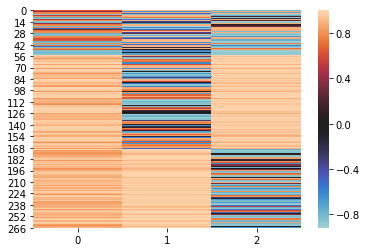

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 53
Task 0 hypothetical scores:


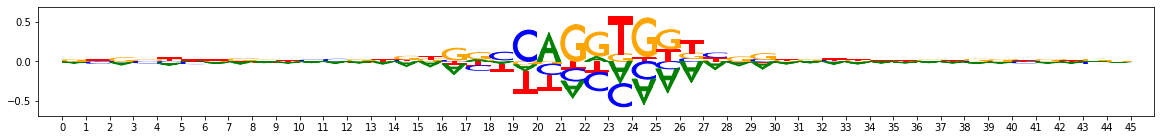

Task 0 actual importance scores:


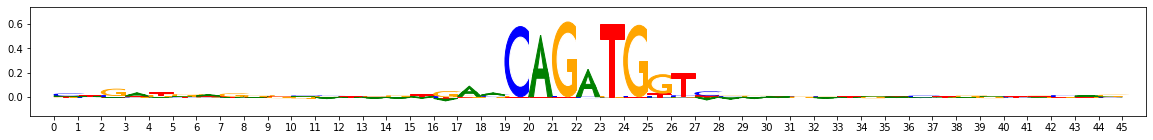

Task 1 hypothetical scores:


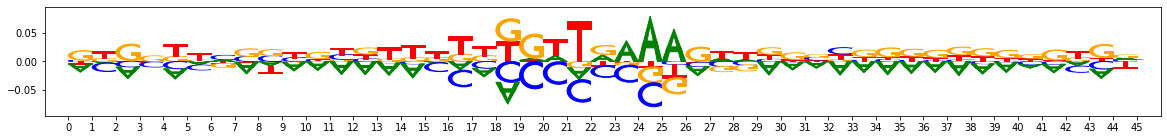

Task 1 actual importance scores:


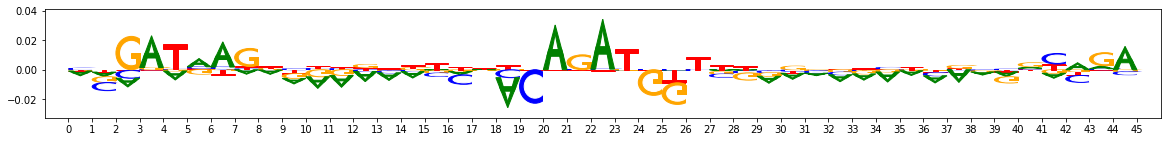

Task 2 hypothetical scores:


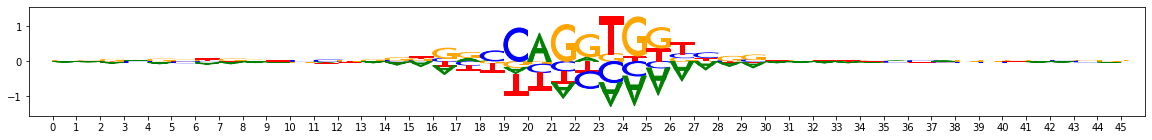

Task 2 actual importance scores:


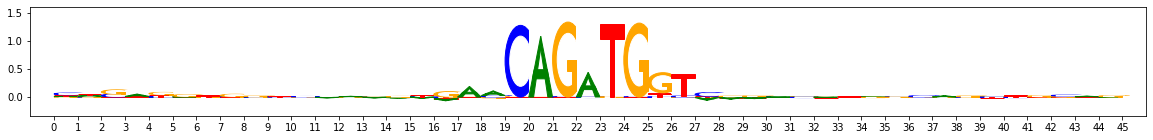

onehot, fwd and rev:


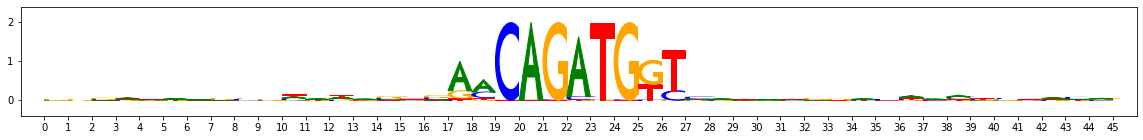

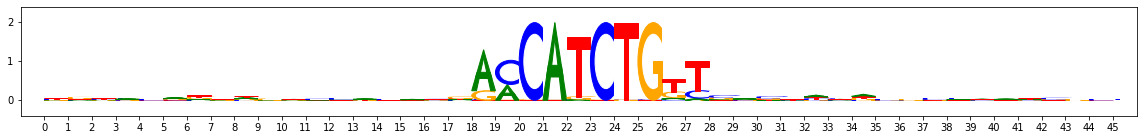

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 56
Task 0 hypothetical scores:


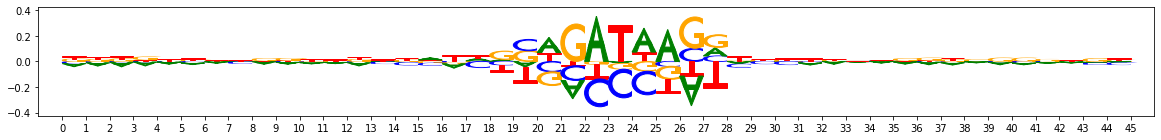

Task 0 actual importance scores:


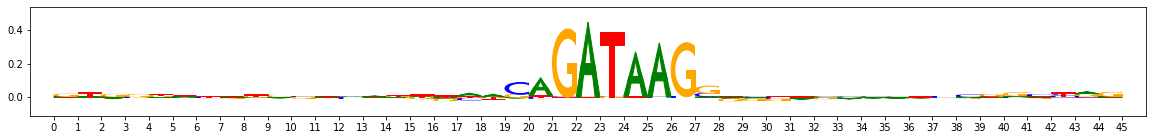

Task 1 hypothetical scores:


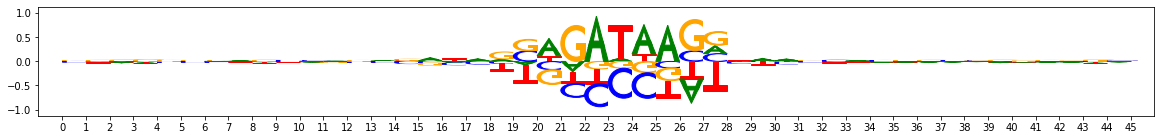

Task 1 actual importance scores:


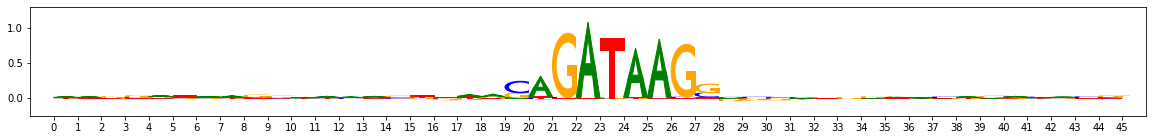

Task 2 hypothetical scores:


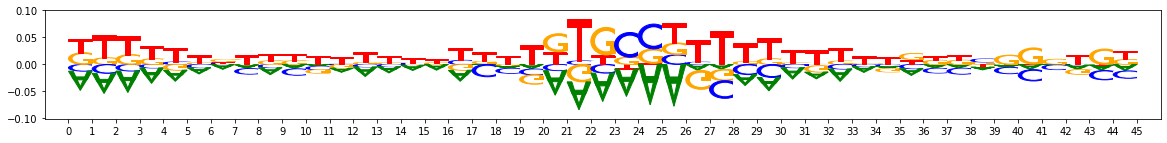

Task 2 actual importance scores:


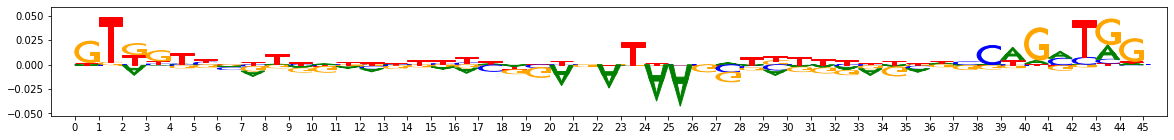

onehot, fwd and rev:


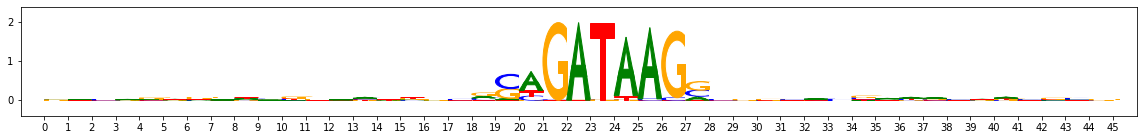

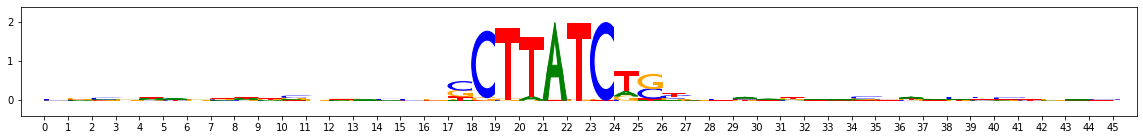

In [34]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

In [71]:
#sanity check...
import numpy as np
seqlets = tfmodisco_results.multitask_seqlet_creation_results.final_seqlets
seqlet_onehot = np.array([x["sequence"].fwd for x in seqlets])


In [42]:
embeddings = embedding_model.predict(seqlet_onehot)

In [43]:
embeddings.shape

(275, 100)

In [48]:
norm_embedding = embeddings/np.linalg.norm(embeddings, axis=-1)[:,None]

In [49]:
embedding_simmat = np.dot(norm_embedding, norm_embedding.T)

In [50]:
embedding_simmat.shape

(275, 275)

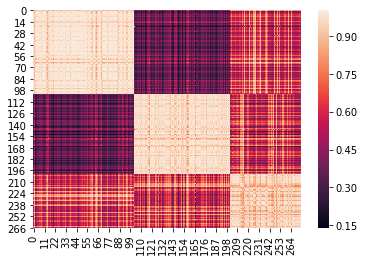

In [80]:
import seaborn as sns
import sklearn.cluster
labels = sklearn.cluster.KMeans(3).fit_predict(embedding_simmat)
ordering = [x[0] for x in sorted(enumerate(labels), key=lambda x: (x[1],x[0]) )]
sns.heatmap(embedding_simmat[ordering,:][:,ordering])

Cluster idx 0
seqlet idx 1


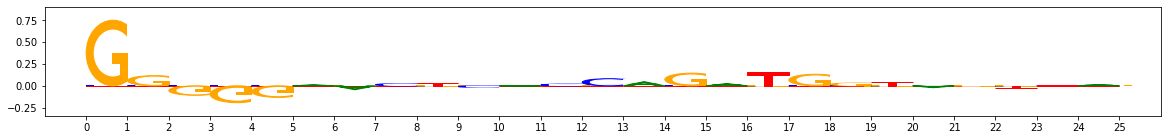

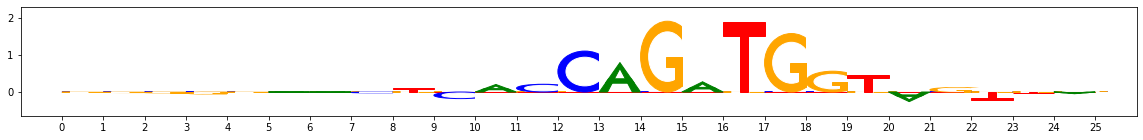

seqlet idx 2


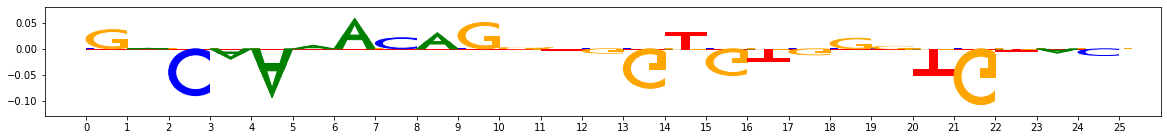

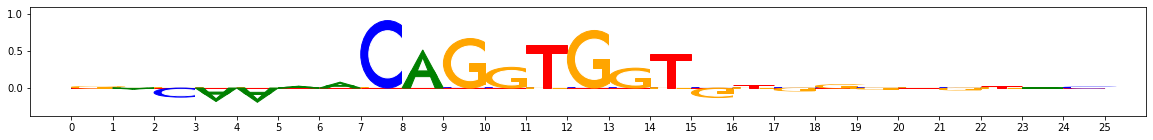

seqlet idx 8


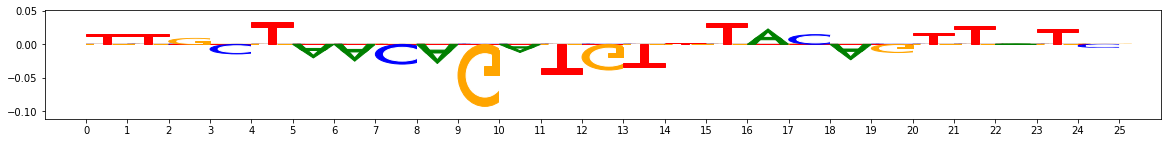

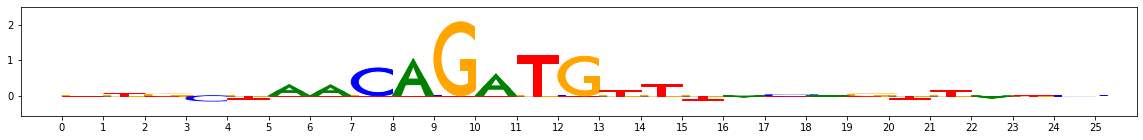

seqlet idx 9


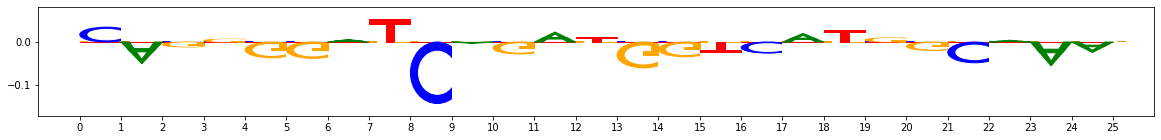

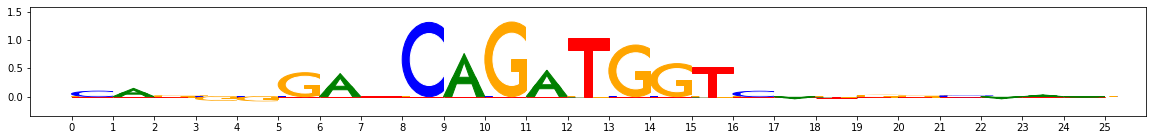

seqlet idx 10


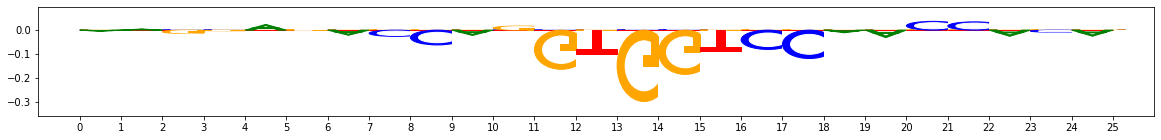

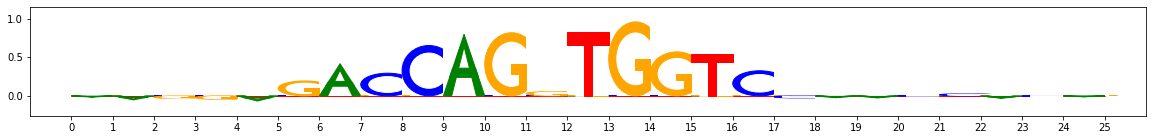

Cluster idx 1
seqlet idx 0


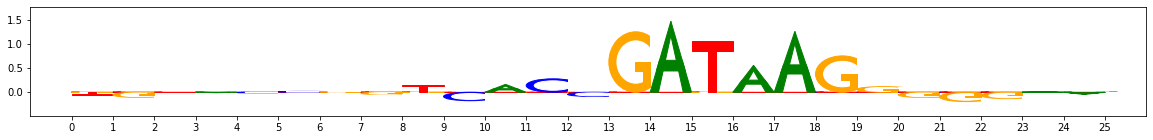

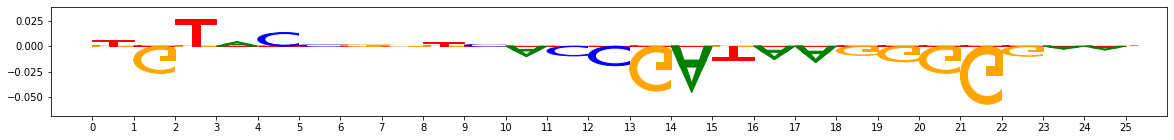

seqlet idx 4


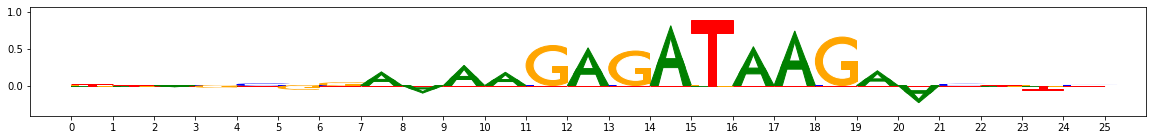

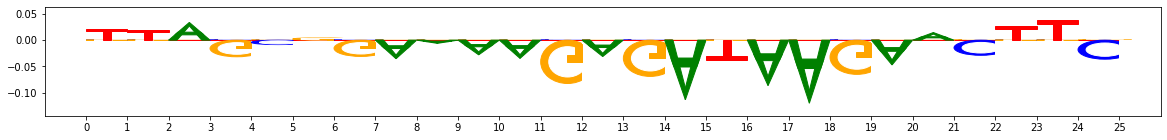

seqlet idx 5


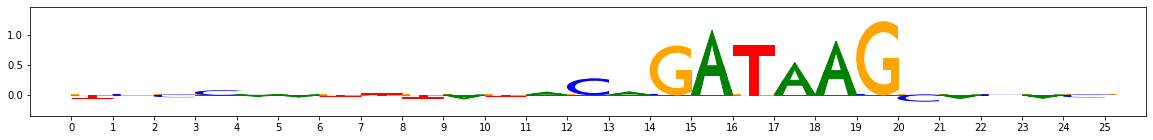

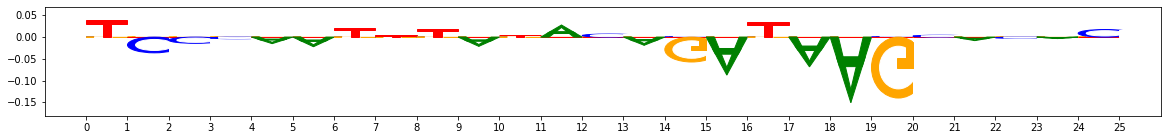

seqlet idx 6


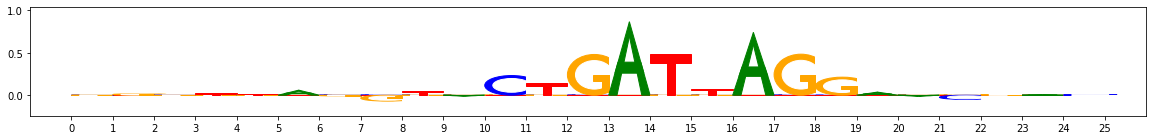

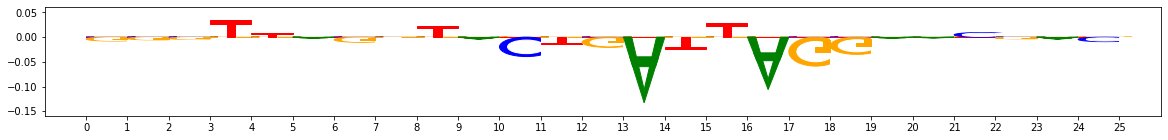

seqlet idx 7


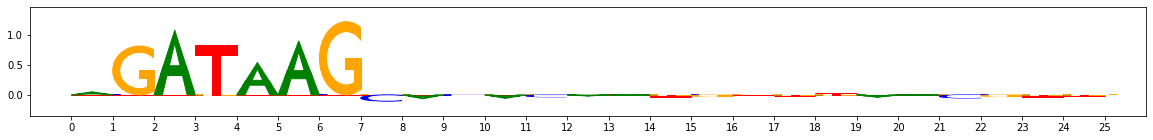

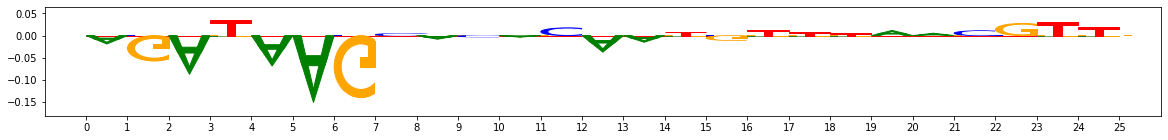

Cluster idx 2
seqlet idx 3


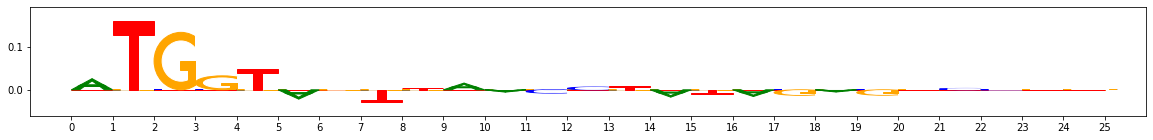

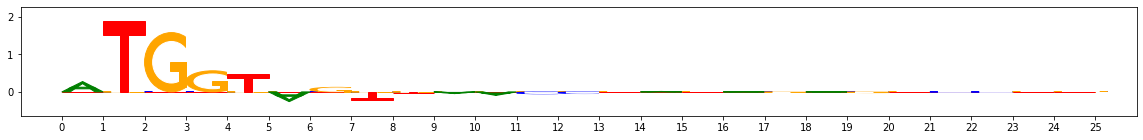

seqlet idx 11


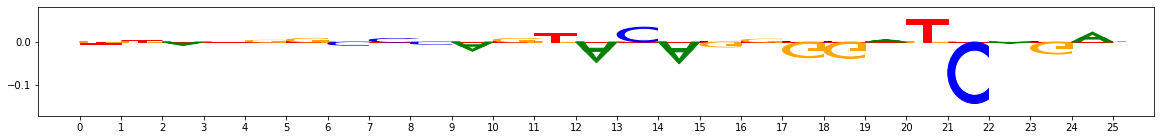

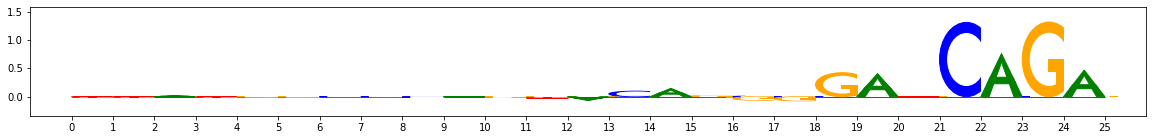

seqlet idx 13


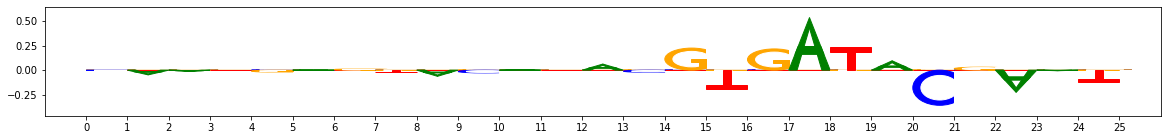

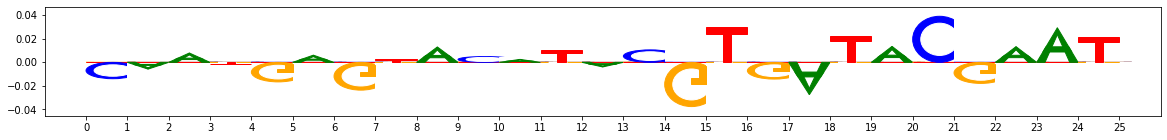

seqlet idx 19


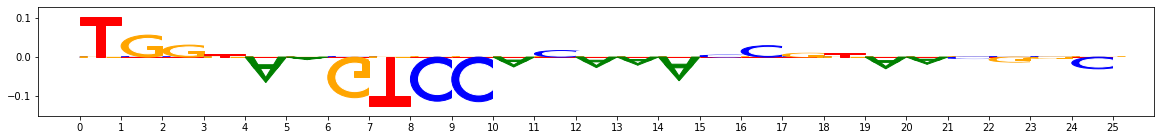

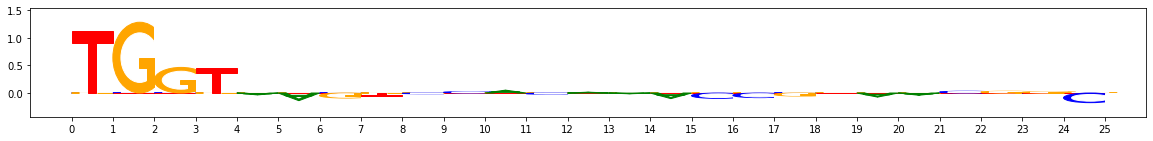

seqlet idx 20


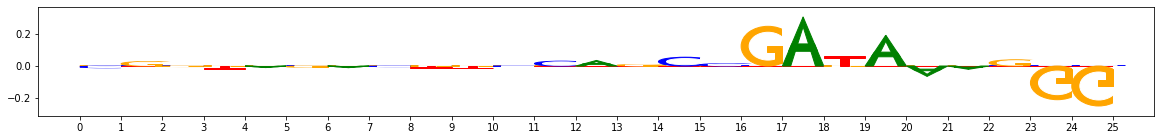

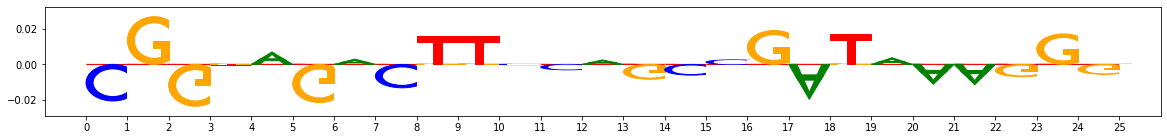

In [82]:
#visualize the 3 clusters
num_to_viz=5
for cluster_idx in range(max(labels+1)):
    print("Cluster idx",cluster_idx)
    indices_in_cluster = np.nonzero(labels==cluster_idx)[0]
    for i in range(num_to_viz):
        seqlet_idx = indices_in_cluster[i]
        print("seqlet idx", seqlet_idx)
        viz_sequence.plot_weights(seqlets[seqlet_idx]["task1_contrib_scores"].fwd)
        viz_sequence.plot_weights(seqlets[seqlet_idx]["task2_contrib_scores"].fwd)